In [1]:
%matplotlib inline

##### Path configuration #####
# Location of Driscoll datasets on your system; Download from 
# https://datadryad.org/stash/dataset/doi:10.5061/dryad.gqnk98sjq
PPC_DATA_PATH = '/home/cfs/mer49/PPC_data/'
# Where to put cache for intermediate results
PY_CACHE_DIR  = './'
# Name of folder in which to cache intermediate processing results
CACHE_NAME    = 'cache'

# Add local libraries to path. A stripped-down copy of neurotools, and 
# some code for extracting the Driscoll datasets, is included. 
# https://github.com/michaelerule/neurotools/blob/master/README.md
import os,sys
sys.path.insert(0,os.path.abspath("./"))
sys.path.insert(0,os.path.abspath("./driscolldatatools/"))

# Pretty ugly: sets up disk caching for procssing Driscoll data
# Caching was useful for exploratory analysis, but is a bit too heavy
# for this paper. I will generate and save the intermediate results, 
# then comment out this code. 
from neurotools.jobs.initialize_system_cache import initialize_caches,cache_test
from neurotools.tools import ensure_dir
ensure_dir(PY_CACHE_DIR+os.sep+CACHE_NAME)
initialize_caches(PY_CACHE_DIR,CACHE_IDENTIFIER=CACHE_NAME)
import neurotools
from   neurotools.nlab import *

# Import Driscoll et al. data wrangling libraries
import ppc_data_loader
ppc_data_loader.path = PPC_DATA_PATH
from ppc_data_loader  import *
from ppc_trial        import *

from config import *

## F1bc: single cell tuning drift from Driscoll et al. 

Examples of tuning curve drift were taken from mouse four in Driscoll et al., which included a subpopulation of cells that were tracked for over a month. Normalized dF/F calcium transients were band-passed filtered between 0.3 and 3 Hz. Individual runs through the T maze were extracted, and calcium fluorescence traces from select cells were aligned based on task pseudotime based on progress through each trial (0 = start, 1 = reward). The activity of each cell was z-scored within each trial, providing a normalized log-fluorescence signal. On each day, normalized log-fluorescence was averaged over all sessions and then exponentiated to generate the average tuning curves shown in Figure 1b. for Figure 1c, a randomly selected subpopulation of forty cells was processes similarly, and sorted based on their peak firing location on the first day.

In [2]:
# Pick a mouse and session, get tracked neurons
mouse    = 4
sessions = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,25]#get_session_ids(mouse)
days     = [0,1,2,3,4,5,6,9,10,11,12,13,17,19,20,24,25,27,29,30,31,38]#get_days(mouse)
days     = array(days)-np.min(days)
daymap   = dict(zip(sessions,days))
TIMERES  = 100  # pseudotime resolution
JITTER   = 25   # event time jitter tolerance
LOWF     = 0.03 # filter cutoffs Hz
HIGHF    = 0.3
NDAYS    = days[-1]
NSESS    = len(sessions)
h        = linspace(0,1,TIMERES)

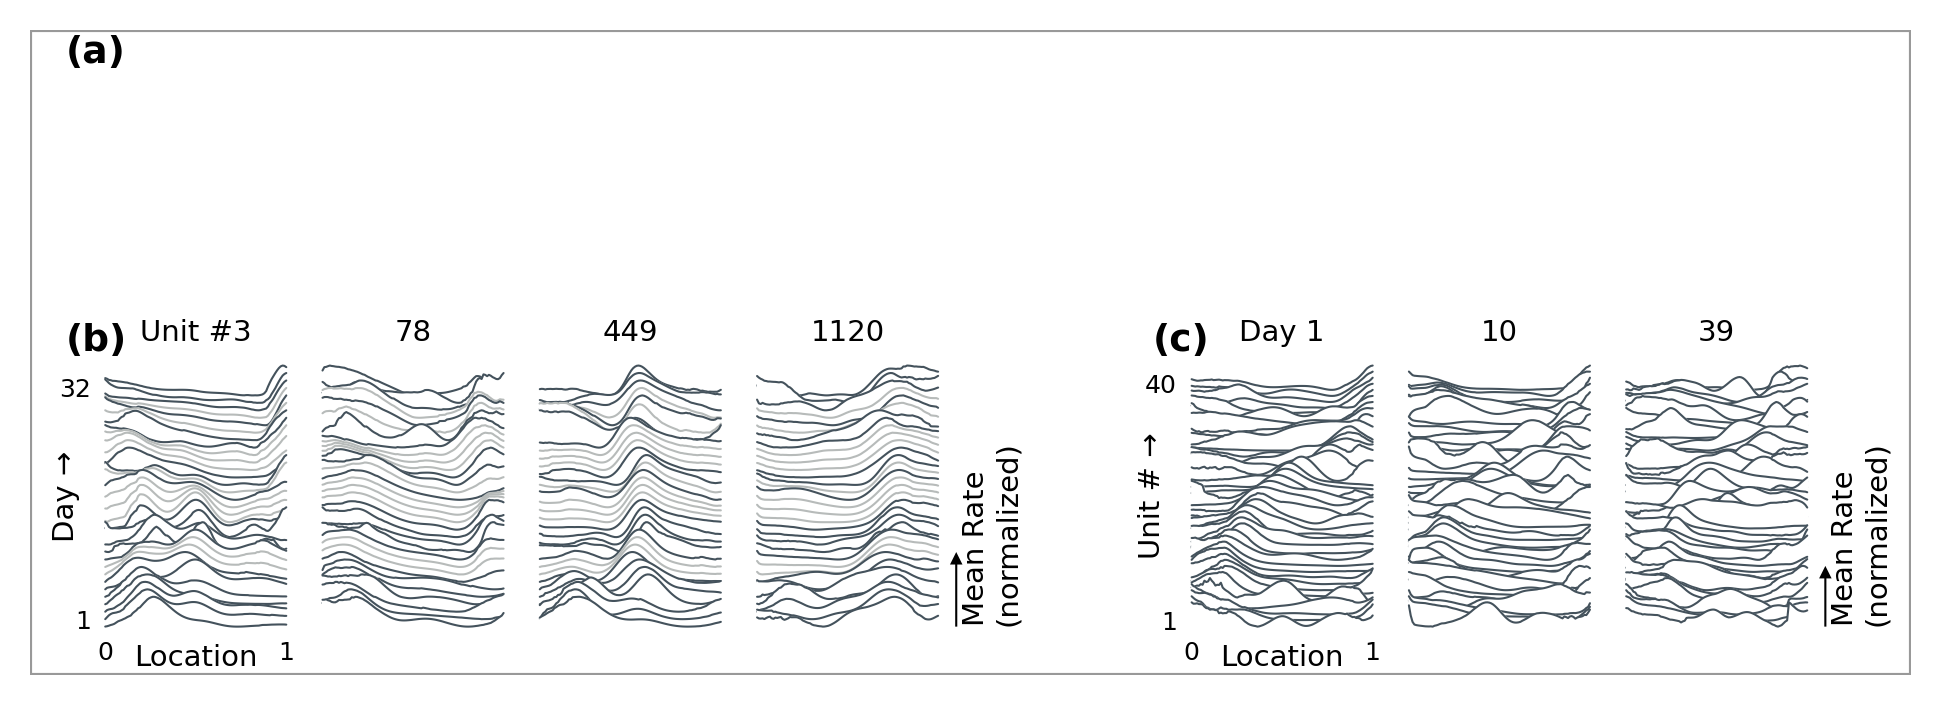

In [11]:
dy = 0.25

def figureB(axs,
            useunits,
            INTERPCOLOR = (BLACK+WHITE*2)/3,
            lw=0.5):
    NSHOW    = len(axs)
    useunits = sorted(useunits[:NSHOW])
    sessions = array(get_session_ids(mouse))
    units    = get_units_in_common(mouse,sessions)[0]
    sessions = array(get_session_ids(mouse))[:-1]
    days     = array(get_days(mouse))[:-1]-1
    NUNIT    = len(units)
    NDAYS    = days[-1]+1
    NSESS    = len(sessions)
    # Get psuedotime aligned respones
    y = [align_trials(mouse,[s],
                      [array([get_smoothed_logF(mouse,s,u,LOWF,HIGHF) for u in units])],
                      PSTIMERES=TIMERES,
                      JITTER   =JITTER,
                      CUE      =None,
                      PREV     =None)[0]
         for s in sessions]
    # Average tuning
    tuning  = exp(array([mean(yi,axis=0) for yi in y]))
    q       = zeros((NDAYS,TIMERES,NUNIT))
    q[days] = tuning
    missing = {*range(NDAYS)}-{*days}
    colors  = [INTERPCOLOR if d in missing else BLACK for d in range(NDAYS)]
    for d in missing:
        a ,b  = max(days[days<d]), min(days[days>d])
        w2,w1 = (d-a)/(b-a), (b-d)/(b-a)
        q[d]  = q[a]*w1 + q[b]*w2
    q -= np.min(q, axis=(0,1))
    q /= np.percentile(q, 95, axis=(0,1))
    ushow = array([find(array(units)==u)[-1] for u in useunits])
    for j in range(NSHOW):
        sca(axs[j])
        u = units[ushow[j]]
        t = q[:,:,ushow[j]]
        for i in range(NDAYS):
            z = unitscale(t[i])+i*dy
            fill_between(h,0,z,facecolor='w',edgecolor='w',lw=lw,zorder=-i,clip_on=False)
            plot(h,z,color=colors[i],zorder=-i,clip_on=False,lw=lw,linestyle='-')
        noxyaxes()
        title(('' if j else 'Unit #')+'%d'%u)
        if not j:
            yticks([dy,NDAYS*dy],['1','%d'%NDAYS]); ylabel('Day →')
            xticks([0,1]); xlabel('Location')
            gca().tick_params('both', length=0, width=0, which='both')
            fudgey(5)
        if j==NSHOW-1: 
            simple_arrow(1.1,0,1.1,dy*10,s=3,lw=0.5,clip_on=False,annotation_clip=False)
            text(1.1+pixels_to_xunits(5),0+dy*0.125,'Mean Rate\n(normalized)',
                 fontsize=7,rotation=90,ha='left',va='bottom')
        xlim(0,1)
        ylim(0,dy*(NDAYS+3))

def figureC(axs,
            NUNITSHOW = 40,
            showsessions = [1,8,14,19,25],
            includemode='random',
            **kwargs
           ):
    NSHOW = len(axs)
    if len(showsessions)>NSHOW: showsessions = showsessions[:NSHOW-1]+showsessions[-1:]
    NSHOW = len(showsessions)
    units = get_units_in_common(mouse,showsessions)[0]
    NUNIT = len(units)
    y = [align_trials(mouse,[s],
                      [array([get_smoothed_logF(mouse,s,u,LOWF,HIGHF)
                              for u in progress_bar|units])],
                      PSTIMERES=TIMERES,
                      JITTER   =JITTER,
                      CUE      =None,
                      PREV     =None)[0]
         for s in showsessions]
    tuning = exp(array([mean(yi,axis=0) for yi in y]))
    use    = np.random.choice(arange(NUNIT),NUNITSHOW,replace=False)
    tuning = tuning[:,:,use]
    units  = array(units)[use]
    NUNIT  = len(units)
    o = argsort(argmax(tuning[0],axis=0))
    for j,(ax,s) in en|zip(axs,showsessions):
        sca(ax)
        t = unitscale(tuning[j],axis=0)[:,o]
        waterfall_plot(h,t.T,dy=dy,draw_ratelabel=j==NSHOW-1,**kwargs)
        if j: noxyaxes();
        else: ylabel('Unit # →'); fudgey(5);
        title(('' if j else 'Day ')+'%d'%(daymap[s]+1))
    return tuning

NSHOWA = 4
NSHOWB = 3
NCOL   = NSHOWA + NSHOWB + 1
figure(figsize=(TEXTWIDTH,2.15),dpi=300)
subplots_adjust(wspace=0.2,hspace=.1,left=0.04,bottom=0.075,top=0.925,right=.945)
axs0 = [subplot2grid((2,NCOL),(0,0),colspan=NCOL)]
axs1 = [subplot2grid((2,NCOL),(1,i))          for i in range(NSHOWA)]
axs2 = [subplot2grid((2,NCOL),(1,NSHOWA+1+i)) for i in range(NSHOWB)]
figureB(axs1,[3,78,449,1120])
figureC(axs2,showsessions = [1,8,25],includemode='random')
sca(axs0[0]); subfigurelabel('(a)',fontsize=9); noxyaxes()
sca(axs1[0]); subfigurelabel('(b)',fontsize=9); fudgex(5)
sca(axs2[0]); subfigurelabel('(c)',fontsize=9); fudgex(5)
figurebox()
savefigure('f1abc_small_v3',stamp=False)

Note: 
    
$$
\ln(1+\text{dFF}) = \ln\left(1 + \frac{x - \mu_x}{\mu_x}\right) = \ln\left(\frac x {\mu_x}\right) = \ln(x) - \ln(\mu_x)
$$
